In [1]:
import pandas as pd
import numpy as np
from os.path import join
import os
import pickle
import requests
from multiprocessing.dummy import Pool
import matplotlib.pyplot as plt
import seaborn as sns
import json

import warnings
warnings.filterwarnings('ignore')
CURRENT_DIR = os.getcwd()
os.chdir(CURRENT_DIR)
CURRENT_DIR


'c:\\Users\\aless\\OneDrive\\Desktop\\Internship_results'

## Script to download the BRENDA dataset and generate ESM-2 enzyme and ChemBERTa-2 substrate representations of wild type and mutant enzymes

Load BRENDA data from json files

In [2]:
directory = "brenda_ec_json_km"

keys_to_extract = ["value", "substrate", "uniprot", "commentary"] 
all_data = []


for filename in os.listdir(directory):
    if filename.endswith(".json"): 
        file_path = os.path.join(directory, filename)

        if os.path.getsize(file_path) == 0:
            continue  

        ec_number = filename.split("-")[0]  

        with open(file_path, encoding="utf-8") as file:
            data = json.load(file)

        if "value" not in data or not isinstance(data["value"], dict):
            continue  

        # Extract data
        extracted_data = [{"ec": ec_number} | {key: data[key].get(str(i), None) if key in data else None for key in keys_to_extract} for i in range(len(data["value"]))]

        all_data.extend(extracted_data)

df = pd.DataFrame(all_data)
df.rename(columns={"value": "km"}, inplace=True)
df["substrate"] = df["substrate"].str.lower()
df

KeyboardInterrupt: 

Set the substrates 

In [ ]:
unique_subst = df[["substrate"]].drop_duplicates().reset_index(drop=True)
unique_subst.to_pickle(join("files","unique_substrates_brenda.pkl"))
unique_subst

,substrate
0,nadh
1,nad+
2,ethanol
3,1-pentanol
4,isobutyraldehyde
...,...
8617,hoechst 33342/in
8618,doxorubicin/in
8619,"s-(2,4-dinitrophenyl)glutathione[side 1]"
8620,s-glutathione[side 1]


Retrive smiles from PubChem

In [ ]:
name_to_smiles = {}

def get_smiles(name):
    try:
        url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{name}/property/CanonicalSMILES/TXT"
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            smiles = response.content.decode().strip()
        else:
            smiles = None
    except:
        smiles = None
    name_to_smiles[name] = smiles

unique = unique_subst["substrate"].dropna().unique().tolist()

thread_pool = Pool(4)
thread_pool.map(get_smiles, unique)
thread_pool.close()
thread_pool.join()

unique_subst["smiles"] = unique_subst["substrate"].map(name_to_smiles)
unique_subst = unique_subst.dropna(subset="smiles")
unique_subst

In [ ]:
unique_subst.to_pickle(join("files", "unique_substrates_smiles_brenda.pkl"))

Add smiles to original dataframe

In [ ]:
unique_subst = pd.read_pickle(join("files", "unique_substrates_smiles_brenda.pkl"))
df = pd.merge(df, unique_subst, on="substrate", how="left")
df = df.dropna(subset=["smiles"]).reset_index(drop=True)
df

,ec,km,substrate,uniprot,commentary,smiles
0,1.1.1.1,0.0710,nadh,D4GSN2,"#10# isoenzyme 2 <51>; #136# pH 6.0, temperatu...",C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...
1,1.1.1.1,0.1000,nad+,B8QU18,#10# isoenzyme ADH-3 <49>; #124# at pH 9.0 in ...,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)([O-])OP(=O...
2,1.1.1.1,0.2000,nad+,P42328,"#10# isoenzyme ADH-1, pH 7.5 <49>; #48# in 0.1...",C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)([O-])OP(=O...
3,1.1.1.1,0.0560,ethanol,Q6L0S1,,CCO
4,1.1.1.1,66.0000,ethanol,P39462,"#109# mutant enzyme W95L/N249Y, in 0.1 M glyci...",CCO
...,...,...,...,...,...,...
40315,7.6.2.9,0.6000,atp,P46920,"#8# wild-type, performed in 10 mM sodium phosp...",C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...
40316,7.6.2.9,1.7000,atp,P46920,"#8# mutant F19W, performed in 10 mM sodium pho...",C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...
40317,7.6.2.9,0.7000,atp,P46920,"#8# mutant S45C, performed in 10 mM sodium pho...",C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...
40318,7.6.2.9,2.8000,atp,P46920,"#8# mutant G161C, performed in 10 mM sodium ph...",C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...


Remove duplicates and incomplete entries

In [ ]:
df = df.drop_duplicates(["ec", "km", "substrate", "uniprot"]) 

df = df.loc[~pd.isnull(df["uniprot"])]
df = df.loc[~pd.isnull(df["substrate"])]
df = df.loc[~pd.isnull(df["km"])]
df = df.loc[~pd.isnull(df["smiles"])]
df = df.reset_index(drop=True)
df

,ec,km,substrate,uniprot,commentary,smiles
0,1.1.1.1,0.0710,nadh,D4GSN2,"#10# isoenzyme 2 <51>; #136# pH 6.0, temperatu...",C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...
1,1.1.1.1,0.1000,nad+,B8QU18,#10# isoenzyme ADH-3 <49>; #124# at pH 9.0 in ...,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)([O-])OP(=O...
2,1.1.1.1,0.2000,nad+,P42328,"#10# isoenzyme ADH-1, pH 7.5 <49>; #48# in 0.1...",C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)([O-])OP(=O...
3,1.1.1.1,0.0560,ethanol,Q6L0S1,,CCO
4,1.1.1.1,66.0000,ethanol,P39462,"#109# mutant enzyme W95L/N249Y, in 0.1 M glyci...",CCO
...,...,...,...,...,...,...
40192,7.6.2.9,0.6000,atp,P46920,"#8# wild-type, performed in 10 mM sodium phosp...",C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...
40193,7.6.2.9,1.7000,atp,P46920,"#8# mutant F19W, performed in 10 mM sodium pho...",C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...
40194,7.6.2.9,0.7000,atp,P46920,"#8# mutant S45C, performed in 10 mM sodium pho...",C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...
40195,7.6.2.9,2.8000,atp,P46920,"#8# mutant G161C, performed in 10 mM sodium ph...",C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...


Extract enzyme type and mutations

In [ ]:
import re

def extract_info(commentary):
    mutations = re.findall(r"[A-Z]\d+[A-Z]", commentary)  
    if mutations:
        enzyme_type = "mutant"
        mutations = "/".join(mutations)  
    else:
        enzyme_type = None
    
    if enzyme_type is None:
        for keyword in ["native", "wild-type", "wild type", "recombinant"]:
            if keyword in commentary:
                enzyme_type = keyword
                break  

    return pd.Series([enzyme_type, mutations])

df[["enzyme_type", "mutations"]] = df["commentary"].apply(extract_info)
df["enzyme_type"] = df["enzyme_type"].replace({None: "wild type"}) #no commentary label found
df = df[df["enzyme_type"] != "recombinant"]
df["enzyme_type"] = df["enzyme_type"].replace({"wild-type": "wild type", "native": "wild type"})
df = df.drop(columns="commentary")
df

,ec,km,substrate,uniprot,smiles,enzyme_type,mutations
0,1.1.1.1,0.0710,nadh,D4GSN2,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,[]
1,1.1.1.1,0.1000,nad+,B8QU18,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)([O-])OP(=O...,mutant,G211S
2,1.1.1.1,0.2000,nad+,P42328,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)([O-])OP(=O...,mutant,W87A
3,1.1.1.1,0.0560,ethanol,Q6L0S1,CCO,wild type,[]
4,1.1.1.1,66.0000,ethanol,P39462,CCO,mutant,W95L/N249Y
...,...,...,...,...,...,...,...
40192,7.6.2.9,0.6000,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,wild type,[]
40193,7.6.2.9,1.7000,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,F19W
40194,7.6.2.9,0.7000,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,S45C
40195,7.6.2.9,2.8000,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,G161C


 Merge and calculate the geometric mean of km values for wild type entries with same EC + Uniprot ID + substrate

In [ ]:
wild_type_df = df[df["enzyme_type"] == "wild type"]

def geometric_mean_values(x):
    return x

geometric_means_values = (wild_type_df.groupby(["ec", "substrate", "uniprot"], as_index=False).agg({"km": geometric_mean_values}))

result_df_wt = pd.merge(wild_type_df, geometric_means_values, on= ["ec", "substrate", "uniprot"], how= "left")
result_df_wt

,ec,km_x,substrate,uniprot,smiles,enzyme_type,mutations,km_y
0,1.1.1.1,0.07100,nadh,D4GSN2,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,[],0.071
1,1.1.1.1,0.05600,ethanol,Q6L0S1,CCO,wild type,[],0.056
2,1.1.1.1,0.26000,isobutyraldehyde,P39462,CC(C)C=O,wild type,[],0.26
3,1.1.1.1,0.41000,(r)-2-butanol,P39462,CCC(C)O,wild type,[],0.41
4,1.1.1.1,0.01200,(s)-2-butanol,P39462,CCC(C)O,wild type,[],0.012
...,...,...,...,...,...,...,...,...
22522,7.6.2.9,0.09190,betaine,Q0PCR9,C[N+](C)(C)CC(=O)[O-],wild type,[],"[0.128, 0.143, 0.272, 0.0608, 0.0834, 0.0919, ..."
22523,7.6.2.9,0.00832,betaine,Q0PCR9,C[N+](C)(C)CC(=O)[O-],wild type,[],"[0.128, 0.143, 0.272, 0.0608, 0.0834, 0.0919, ..."
22524,7.6.2.9,0.00941,betaine,Q0PCR9,C[N+](C)(C)CC(=O)[O-],wild type,[],"[0.128, 0.143, 0.272, 0.0608, 0.0834, 0.0919, ..."
22525,7.6.2.9,0.60000,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,wild type,[],0.6


In [ ]:
from scipy.stats import gmean

result_df_wt["km_y"] = result_df_wt["km_y"].apply(lambda x: list(x) if isinstance(x, (list, np.ndarray)) else [x])

result_df_wt["km_count"] = result_df_wt["km_y"].apply(len)

result_df_wt.drop(columns=["km_x"], inplace=True)

result_df_wt = result_df_wt.rename(columns={"km_y":"km"})

def calculate_geometric_mean(value):
    if isinstance(value, list):
        return gmean(value)
    
    return value  

result_df_wt["km_gmean"] = result_df_wt["km"].apply(calculate_geometric_mean)

result_df_wt = result_df_wt.drop_duplicates(subset = ["ec", "substrate", "uniprot", "km_gmean"])
result_df_wt.reset_index(drop=True, inplace=True)
result_df_wt

,ec,substrate,uniprot,smiles,enzyme_type,mutations,km,km_count,km_gmean
0,1.1.1.1,nadh,D4GSN2,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,[],[0.071],1,0.071000
1,1.1.1.1,ethanol,Q6L0S1,CCO,wild type,[],[0.056],1,0.056000
2,1.1.1.1,isobutyraldehyde,P39462,CC(C)C=O,wild type,[],[0.26],1,0.260000
3,1.1.1.1,(r)-2-butanol,P39462,CCC(C)O,wild type,[],[0.41],1,0.410000
4,1.1.1.1,(s)-2-butanol,P39462,CCC(C)O,wild type,[],[0.012],1,0.012000
...,...,...,...,...,...,...,...,...,...
17595,7.6.2.3,atp,Q8QG98,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,wild type,[],"[0.5, 0.4]",2,0.447214
17596,7.6.2.3,atp,P39109,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,wild type,[],[0.0865],1,0.086500
17597,7.6.2.9,betaine,Q0PCR9,C[N+](C)(C)CC(=O)[O-],wild type,[],"[0.128, 0.143, 0.272, 0.0608, 0.0834, 0.0919, ...",8,0.060590
17598,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,wild type,[],[0.6],1,0.600000


In [ ]:
result_df_wt.to_pickle(join("files", "wild_type_gmeans_brenda.pkl"))

 Merge and calculate the geometric mean of km values for mutant entries with same EC + Uniprot ID + substrate + mutation

In [66]:
mutants_df = df[df["enzyme_type"] == "mutant"]

def geometric_mean_values(x):
    return x

geometric_means_values = (mutants_df.groupby(["ec", "substrate", "mutations", "uniprot"], as_index=False).agg({"km": geometric_mean_values}))

result_df_mut = pd.merge(mutants_df, geometric_means_values, on= ["ec", "substrate", "mutations", "uniprot"], how= "left")
result_df_mut

,ec,km_x,substrate,uniprot,smiles,enzyme_type,mutations,km_y
0,1.1.1.1,0.100,nad+,B8QU18,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)([O-])OP(=O...,mutant,G211S,0.1
1,1.1.1.1,0.200,nad+,P42328,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)([O-])OP(=O...,mutant,W87A,0.2
2,1.1.1.1,66.000,ethanol,P39462,CCO,mutant,W95L/N249Y,66.0
3,1.1.1.1,0.260,1-pentanol,P39462,CCCCCO,mutant,W95L,0.26
4,1.1.1.1,0.008,nadh,P39462,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,mutant,W95L,0.008
...,...,...,...,...,...,...,...,...
14539,7.6.2.1,0.394,atp,C7EXK4,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,L112A,"[0.045, 0.394]"
14540,7.6.2.1,2.215,atp,C7EXK4,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,N359A,"[0.22, 2.215]"
14541,7.6.2.9,1.700,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,F19W,1.7
14542,7.6.2.9,0.700,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,S45C,0.7


In [67]:
from scipy.stats import gmean 

result_df_mut["km_y"] = result_df_mut["km_y"].apply(lambda x: list(x) if isinstance(x, (list, np.ndarray)) else [x])

result_df_mut ["km_count"] = result_df_mut ["km_y"].apply(len)

result_df_mut .drop(columns=["km_x"], inplace=True)

result_df_mut  = result_df_mut .rename(columns={"km_y":"km"})

def calculate_geometric_mean(value):
    if isinstance(value, list):
        return gmean(value)
    return value  

result_df_mut ["km_gmean"] = result_df_mut ["km"].apply(calculate_geometric_mean)

result_df_mut  = result_df_mut.drop_duplicates(subset = ["ec", "mutations", "substrate", "uniprot", "km_gmean"])
result_df_mut.reset_index(drop=True, inplace=True)
result_df_mut 

,ec,substrate,uniprot,smiles,enzyme_type,mutations,km,km_count,km_gmean
0,1.1.1.1,nad+,B8QU18,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)([O-])OP(=O...,mutant,G211S,[0.1],1,0.100000
1,1.1.1.1,nad+,P42328,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)([O-])OP(=O...,mutant,W87A,[0.2],1,0.200000
2,1.1.1.1,ethanol,P39462,CCO,mutant,W95L/N249Y,[66.0],1,66.000000
3,1.1.1.1,1-pentanol,P39462,CCCCCO,mutant,W95L,[0.26],1,0.260000
4,1.1.1.1,nadh,P39462,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,mutant,W95L,[0.008],1,0.008000
...,...,...,...,...,...,...,...,...,...
13596,7.6.2.1,atp,C7EXK4,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,I364M,"[0.369, 0.148]",2,0.233692
13597,7.6.2.1,atp,C7EXK4,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,V906A,[0.103],1,0.103000
13598,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,F19W,[1.7],1,1.700000
13599,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,S45C,[0.7],1,0.700000


In [ ]:
result_df_mut.to_pickle(join("files","mutants_gmeans_brenda.pkl"))

Merge dataframes 

In [21]:
wt_df = pd.read_pickle(join("files", "wild_type_gmeans_brenda.pkl"))
mut_df = pd.read_pickle(join("files","mutants_gmeans_brenda.pkl"))

km_df = pd.concat([wt_df, mut_df ], ignore_index = True)
km_df 

,ec,substrate,uniprot,smiles,enzyme_type,mutations,km,km_count,km_gmean
0,1.1.1.1,nadh,D4GSN2,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,[],[0.071],1,0.071000
1,1.1.1.1,ethanol,Q6L0S1,CCO,wild type,[],[0.056],1,0.056000
2,1.1.1.1,isobutyraldehyde,P39462,CC(C)C=O,wild type,[],[0.26],1,0.260000
3,1.1.1.1,(r)-2-butanol,P39462,CCC(C)O,wild type,[],[0.41],1,0.410000
4,1.1.1.1,(s)-2-butanol,P39462,CCC(C)O,wild type,[],[0.012],1,0.012000
...,...,...,...,...,...,...,...,...,...
31196,7.6.2.1,atp,C7EXK4,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,I364M,"[0.369, 0.148]",2,0.233692
31197,7.6.2.1,atp,C7EXK4,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,V906A,[0.103],1,0.103000
31198,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,F19W,[1.7],1,1.700000
31199,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,S45C,[0.7],1,0.700000


In [22]:
tot_mut = (km_df ["enzyme_type"] == "mutant").sum()
print(tot_mut)

tot_wt = (km_df ["enzyme_type"] == "wild type").sum()
print(tot_wt)

13601
17600


Log transform the geometrical mean values

In [23]:
def compute_log10_km(row):
    value = row["km_gmean"]
    if isinstance(value, (int, float, np.float64)):
        return np.log10(value) 

km_df["log_km"] = km_df.apply(compute_log10_km, axis=1)
km_df 

,ec,substrate,uniprot,smiles,enzyme_type,mutations,km,km_count,km_gmean,log_km
0,1.1.1.1,nadh,D4GSN2,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,[],[0.071],1,0.071000,-1.148742
1,1.1.1.1,ethanol,Q6L0S1,CCO,wild type,[],[0.056],1,0.056000,-1.251812
2,1.1.1.1,isobutyraldehyde,P39462,CC(C)C=O,wild type,[],[0.26],1,0.260000,-0.585027
3,1.1.1.1,(r)-2-butanol,P39462,CCC(C)O,wild type,[],[0.41],1,0.410000,-0.387216
4,1.1.1.1,(s)-2-butanol,P39462,CCC(C)O,wild type,[],[0.012],1,0.012000,-1.920819
...,...,...,...,...,...,...,...,...,...,...
31196,7.6.2.1,atp,C7EXK4,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,I364M,"[0.369, 0.148]",2,0.233692,-0.631356
31197,7.6.2.1,atp,C7EXK4,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,V906A,[0.103],1,0.103000,-0.987163
31198,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,F19W,[1.7],1,1.700000,0.230449
31199,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,S45C,[0.7],1,0.700000,-0.154902


In [24]:
km_df = km_df[(km_df["log_km"] >= -6) & (km_df["log_km"] <= 4)]

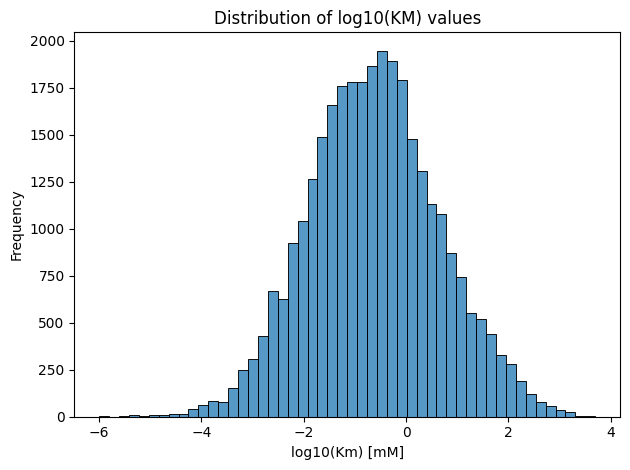

In [7]:
# Plot the distribution
fig, ax = plt.subplots()
sns.histplot(km_df["log_km"], bins=50)

ax.set_title("Distribution of log10(KM) values")
ax.set_xlabel("log10(Km) [mM]")
ax.set_ylabel("Frequency")

#plt.grid(True)
plt.tight_layout()
plt.show()

Download amino acid sequences for all data points

In [74]:
# Save all unique Uniprot IDs
IDs = list(set(km_df["uniprot"]))

with open("esm2/UNIPROT_IDs_brenda_v2.txt", "w") as file:
    for ID in IDs:
        file.write(str(ID) + "\n")

Map Uniprot IDs to amino acid sequence

In [14]:
# Map from https://www.uniprot.org/id-mapping uniprot IDs to amino acid sequences
sequence_df = pd.read_csv(("esm2/idmapping_brenda_final_v2.tsv"), sep = "\t")

sequence_df.drop(columns = ["From"], inplace = True)
sequence_df.rename(columns={"Entry": "uniprot"}, inplace=True)

sequence_df["Sequence ID"] = "sequence_" + (sequence_df.index).astype(str)
sequence_df

,uniprot,Sequence,Sequence ID
0,I3RFR4,MEITVEYIGKNPKEKEHSTIFTLSNGYFSIKGDLELEQSEFGTIVA...,sequence_0
1,D0VX20,TIPKWWKEAVFYQVYPRSFKDTNGDGIGDINGIIEKLDYLKALGID...,sequence_1
2,P24397,MATFVSNWSTKSVSESFIAPLQKRAEKDVPVGNDVPIIDLQQHHHL...,sequence_2
3,Q9FCA7,MATLCRPSVSVPEHVITMEETLELARRRHTDHPQLPLALRLIENTG...,sequence_3
4,Q8PDA8,MPVDKNLRDLEPGIHTDLEGRLTYGGYLRLDQLLSAQQPLSEPAHH...,sequence_4
...,...,...,...
7076,Q0P8J7,MFIGITQRLICNDSYHEKRECLALDWGKLFNKDLFKNFTPLPLSYE...,sequence_7076
7077,I3ZR32,MVMENPFEGKEIWFGVGSQDLYGEEALRQVAIHSAEMVDYLNNTGK...,sequence_7077
7078,P05364,MMRKSLCCALLLGISCSALATPVSEKQLAEVVANTITPLMKAQSVP...,sequence_7078
7079,Q9HY13,MSQILPSQDELLAHAAAEPAFAAWLQGHGPLQHSAETRAAVFRTAH...,sequence_7079


In [15]:
sequence_df = sequence_df.drop_duplicates(subset=["uniprot"])
sequence_df

,uniprot,Sequence,Sequence ID
0,I3RFR4,MEITVEYIGKNPKEKEHSTIFTLSNGYFSIKGDLELEQSEFGTIVA...,sequence_0
1,D0VX20,TIPKWWKEAVFYQVYPRSFKDTNGDGIGDINGIIEKLDYLKALGID...,sequence_1
2,P24397,MATFVSNWSTKSVSESFIAPLQKRAEKDVPVGNDVPIIDLQQHHHL...,sequence_2
3,Q9FCA7,MATLCRPSVSVPEHVITMEETLELARRRHTDHPQLPLALRLIENTG...,sequence_3
4,Q8PDA8,MPVDKNLRDLEPGIHTDLEGRLTYGGYLRLDQLLSAQQPLSEPAHH...,sequence_4
...,...,...,...
7076,Q0P8J7,MFIGITQRLICNDSYHEKRECLALDWGKLFNKDLFKNFTPLPLSYE...,sequence_7076
7077,I3ZR32,MVMENPFEGKEIWFGVGSQDLYGEEALRQVAIHSAEMVDYLNNTGK...,sequence_7077
7078,P05364,MMRKSLCCALLLGISCSALATPVSEKQLAEVVANTITPLMKAQSVP...,sequence_7078
7079,Q9HY13,MSQILPSQDELLAHAAAEPAFAAWLQGHGPLQHSAETRAAVFRTAH...,sequence_7079


In [16]:
sequence_df = sequence_df.drop_duplicates(subset=["Sequence"]) #different uniprot id but same sequence
sequence_df

,uniprot,Sequence,Sequence ID
0,I3RFR4,MEITVEYIGKNPKEKEHSTIFTLSNGYFSIKGDLELEQSEFGTIVA...,sequence_0
1,D0VX20,TIPKWWKEAVFYQVYPRSFKDTNGDGIGDINGIIEKLDYLKALGID...,sequence_1
2,P24397,MATFVSNWSTKSVSESFIAPLQKRAEKDVPVGNDVPIIDLQQHHHL...,sequence_2
3,Q9FCA7,MATLCRPSVSVPEHVITMEETLELARRRHTDHPQLPLALRLIENTG...,sequence_3
4,Q8PDA8,MPVDKNLRDLEPGIHTDLEGRLTYGGYLRLDQLLSAQQPLSEPAHH...,sequence_4
...,...,...,...
7076,Q0P8J7,MFIGITQRLICNDSYHEKRECLALDWGKLFNKDLFKNFTPLPLSYE...,sequence_7076
7077,I3ZR32,MVMENPFEGKEIWFGVGSQDLYGEEALRQVAIHSAEMVDYLNNTGK...,sequence_7077
7078,P05364,MMRKSLCCALLLGISCSALATPVSEKQLAEVVANTITPLMKAQSVP...,sequence_7078
7079,Q9HY13,MSQILPSQDELLAHAAAEPAFAAWLQGHGPLQHSAETRAAVFRTAH...,sequence_7079


In [17]:
# Delete sequences with less than 40 residues or NaN
sequence_df = sequence_df.dropna(subset=["Sequence"])
sequence_df = sequence_df[sequence_df["Sequence"].str.len() >= 40]

sequence_df

,uniprot,Sequence,Sequence ID
0,I3RFR4,MEITVEYIGKNPKEKEHSTIFTLSNGYFSIKGDLELEQSEFGTIVA...,sequence_0
1,D0VX20,TIPKWWKEAVFYQVYPRSFKDTNGDGIGDINGIIEKLDYLKALGID...,sequence_1
2,P24397,MATFVSNWSTKSVSESFIAPLQKRAEKDVPVGNDVPIIDLQQHHHL...,sequence_2
3,Q9FCA7,MATLCRPSVSVPEHVITMEETLELARRRHTDHPQLPLALRLIENTG...,sequence_3
4,Q8PDA8,MPVDKNLRDLEPGIHTDLEGRLTYGGYLRLDQLLSAQQPLSEPAHH...,sequence_4
...,...,...,...
7076,Q0P8J7,MFIGITQRLICNDSYHEKRECLALDWGKLFNKDLFKNFTPLPLSYE...,sequence_7076
7077,I3ZR32,MVMENPFEGKEIWFGVGSQDLYGEEALRQVAIHSAEMVDYLNNTGK...,sequence_7077
7078,P05364,MMRKSLCCALLLGISCSALATPVSEKQLAEVVANTITPLMKAQSVP...,sequence_7078
7079,Q9HY13,MSQILPSQDELLAHAAAEPAFAAWLQGHGPLQHSAETRAAVFRTAH...,sequence_7079


Merge dataframes to include enzyme sequences

In [18]:
km_df = pd.merge(km_df, sequence_df, how = "left", on = "uniprot")
km_df.rename(columns={"Sequence ID": "sequence_id"}, inplace=True)
km_df

,ec,substrate,uniprot,smiles,enzyme_type,mutations,km,km_count,km_gmean,log_km,Sequence,sequence_id
0,1.1.1.1,nadh,D4GSN2,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,[],[0.071],1,0.071000,-1.148742,MRAAVLREHGEPLDVTEVPDPTCDADGVVVEVEACGICRSDWHSWM...,sequence_6568
1,1.1.1.1,ethanol,Q6L0S1,CCO,wild type,[],[0.056],1,0.056000,-1.251812,MRAIVLERFGIENIKIEDIDDESPGIPVKITMAGLNPVDYSTVNGN...,sequence_2418
2,1.1.1.1,isobutyraldehyde,P39462,CC(C)C=O,wild type,[],[0.26],1,0.260000,-0.585027,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,sequence_6350
3,1.1.1.1,(r)-2-butanol,P39462,CCC(C)O,wild type,[],[0.41],1,0.410000,-0.387216,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,sequence_6350
4,1.1.1.1,(s)-2-butanol,P39462,CCC(C)O,wild type,[],[0.012],1,0.012000,-1.920819,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,sequence_6350
...,...,...,...,...,...,...,...,...,...,...,...,...
31184,7.6.2.1,atp,C7EXK4,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,I364M,"[0.369, 0.148]",2,0.233692,-0.631356,MSRATSVGDQLDVPARTIYLNQPHLNKFCDNQISTAKYSVVTFLPR...,sequence_1085
31185,7.6.2.1,atp,C7EXK4,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,V906A,[0.103],1,0.103000,-0.987163,MSRATSVGDQLDVPARTIYLNQPHLNKFCDNQISTAKYSVVTFLPR...,sequence_1085
31186,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,F19W,[1.7],1,1.700000,0.230449,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_4713
31187,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,S45C,[0.7],1,0.700000,-0.154902,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_4713


In [11]:
unique_uniprot_ids = set(km_df["uniprot"])
df_seq = pd.DataFrame(list(unique_uniprot_ids), columns=["uniprot"])
df_seq

,uniprot
0,Q4DGV2
1,Q76KA9
2,Q57981
3,P00183
4,J7LP58
...,...
7073,A3MUZ0
7074,Q4AED2
7075,P07874
7076,Q70KH9


In [12]:
import pandas as pd
import requests
from Bio import SeqIO
from io import StringIO

df = df_seq.copy()

def fetch_sequence(uniprot_id):
    base_url = "https://www.uniprot.org/uniprot/"
    url = f"{base_url}{uniprot_id}.fasta"
    response = requests.get(url)
    if response.status_code == 200 and response.text.strip():
        fasta_io = StringIO(response.text)
        records = list(SeqIO.parse(fasta_io, "fasta"))
        if records:
            return str(records[0].seq)
        else:
            print(f"No sequence records found for {uniprot_id}")
            return None
    else:
        print(f"Failed to fetch sequence for {uniprot_id} (status code {response.status_code})")
        return None


# Add sequence column by applying the fetch function
df['Sequence'] = df['uniprot'].apply(fetch_sequence)
df


Failed to fetch sequence for J9H7D1 (status code 200)
Failed to fetch sequence for A0A1W6VPA7 (status code 200)
Failed to fetch sequence for A5VEL7 (status code 200)
Failed to fetch sequence for A0A0U4QBJ6 (status code 200)
Failed to fetch sequence for A0A1B1EI54 (status code 200)
Failed to fetch sequence for A0A124C1Y7 (status code 200)
Failed to fetch sequence for Q8PK83 (status code 200)
Failed to fetch sequence for A4QEK4 (status code 200)
Failed to fetch sequence for Q9S3U5 (status code 200)
Failed to fetch sequence for A0A5K1QBJ4 (status code 200)
Failed to fetch sequence for W0BU85 (status code 200)
Failed to fetch sequence for M4KX93 (status code 200)
Failed to fetch sequence for A0A0U5KG73 (status code 200)
Failed to fetch sequence for Q5XA29 (status code 200)
Failed to fetch sequence for B7DR33 (status code 200)
Failed to fetch sequence for A0A090SK43 (status code 200)
Failed to fetch sequence for A0A1V3Y1D0 (status code 200)
Failed to fetch sequence for A0A8B4R7U8 (status co

,uniprot,Sequence
0,Q4DGV2,MTCLKLNLLDHVFANPFMNAAGVLCSTEEDLRCMTASSSGALVSKS...
1,Q76KA9,MASFSVKFSATSLPNHKRFSKLHATPPQTVAVAPSGAAEIASERLE...
2,Q57981,MKKVVLLTCTIIVGGQWGDEGKGKIISYICDKDKPSIIARGGVGPN...
3,P00183,MTTETIQSNANLAPLPPHVPEHLVFDFDMYNPSNLSAGVQEAWAVL...
4,J7LP58,MALAKESSIVVSSSPDVTHNITRPVASYHPNVWGDRFLLSSSDQVQ...
...,...,...
7073,A3MUZ0,MAKYLGIDVGATWTRAILVDEGGSVLSRAKIRTGVSPVAEIAEVVA...
7074,Q4AED2,MATNTDKYEAEENFPDFSRQDSMVRTHLTQDMYKNLFKKLTPLGVS...
7075,P07874,MIPVILSGGSGSRLWPLSRKQYPKQFLALTGDDTLFQQTIKRLAFD...
7076,Q70KH9,MREEQPHLATTWAARGWVEEEGIGSATLGRLVRAWPRRAAVVNKAD...


In [13]:
df = df.dropna()
df

,uniprot,Sequence
0,Q4DGV2,MTCLKLNLLDHVFANPFMNAAGVLCSTEEDLRCMTASSSGALVSKS...
1,Q76KA9,MASFSVKFSATSLPNHKRFSKLHATPPQTVAVAPSGAAEIASERLE...
2,Q57981,MKKVVLLTCTIIVGGQWGDEGKGKIISYICDKDKPSIIARGGVGPN...
3,P00183,MTTETIQSNANLAPLPPHVPEHLVFDFDMYNPSNLSAGVQEAWAVL...
4,J7LP58,MALAKESSIVVSSSPDVTHNITRPVASYHPNVWGDRFLLSSSDQVQ...
...,...,...
7073,A3MUZ0,MAKYLGIDVGATWTRAILVDEGGSVLSRAKIRTGVSPVAEIAEVVA...
7074,Q4AED2,MATNTDKYEAEENFPDFSRQDSMVRTHLTQDMYKNLFKKLTPLGVS...
7075,P07874,MIPVILSGGSGSRLWPLSRKQYPKQFLALTGDDTLFQQTIKRLAFD...
7076,Q70KH9,MREEQPHLATTWAARGWVEEEGIGSATLGRLVRAWPRRAAVVNKAD...


In [19]:
df['sequence_id'] = ['sequence_' + str(i) for i in range(len(df))]
df

,uniprot,Sequence,sequence_id
0,Q4DGV2,MTCLKLNLLDHVFANPFMNAAGVLCSTEEDLRCMTASSSGALVSKS...,sequence_0
1,Q76KA9,MASFSVKFSATSLPNHKRFSKLHATPPQTVAVAPSGAAEIASERLE...,sequence_1
2,Q57981,MKKVVLLTCTIIVGGQWGDEGKGKIISYICDKDKPSIIARGGVGPN...,sequence_2
3,P00183,MTTETIQSNANLAPLPPHVPEHLVFDFDMYNPSNLSAGVQEAWAVL...,sequence_3
4,J7LP58,MALAKESSIVVSSSPDVTHNITRPVASYHPNVWGDRFLLSSSDQVQ...,sequence_4
...,...,...,...
7073,A3MUZ0,MAKYLGIDVGATWTRAILVDEGGSVLSRAKIRTGVSPVAEIAEVVA...,sequence_7007
7074,Q4AED2,MATNTDKYEAEENFPDFSRQDSMVRTHLTQDMYKNLFKKLTPLGVS...,sequence_7008
7075,P07874,MIPVILSGGSGSRLWPLSRKQYPKQFLALTGDDTLFQQTIKRLAFD...,sequence_7009
7076,Q70KH9,MREEQPHLATTWAARGWVEEEGIGSATLGRLVRAWPRRAAVVNKAD...,sequence_7010


In [20]:
df.to_pickle("sequence_biopython_brenda.pkl")

In [25]:
km_df = pd.merge(km_df, df, how = "left", on = "uniprot")
km_df

,ec,substrate,uniprot,smiles,enzyme_type,mutations,km,km_count,km_gmean,log_km,Sequence,sequence_id
0,1.1.1.1,nadh,D4GSN2,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,[],[0.071],1,0.071000,-1.148742,MRAAVLREHGEPLDVTEVPDPTCDADGVVVEVEACGICRSDWHSWM...,sequence_3876
1,1.1.1.1,ethanol,Q6L0S1,CCO,wild type,[],[0.056],1,0.056000,-1.251812,MRAIVLERFGIENIKIEDIDDESPGIPVKITMAGLNPVDYSTVNGN...,sequence_5148
2,1.1.1.1,isobutyraldehyde,P39462,CC(C)C=O,wild type,[],[0.26],1,0.260000,-0.585027,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,sequence_6118
3,1.1.1.1,(r)-2-butanol,P39462,CCC(C)O,wild type,[],[0.41],1,0.410000,-0.387216,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,sequence_6118
4,1.1.1.1,(s)-2-butanol,P39462,CCC(C)O,wild type,[],[0.012],1,0.012000,-1.920819,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,sequence_6118
...,...,...,...,...,...,...,...,...,...,...,...,...
31184,7.6.2.1,atp,C7EXK4,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,I364M,"[0.369, 0.148]",2,0.233692,-0.631356,MSRATSVGDQLDVPARTIYLNQPHLNKFCDNQISTAKYSVVTFLPR...,sequence_4885
31185,7.6.2.1,atp,C7EXK4,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,V906A,[0.103],1,0.103000,-0.987163,MSRATSVGDQLDVPARTIYLNQPHLNKFCDNQISTAKYSVVTFLPR...,sequence_4885
31186,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,F19W,[1.7],1,1.700000,0.230449,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_620
31187,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,S45C,[0.7],1,0.700000,-0.154902,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_620


In [26]:
km_df["mutations"] = km_df["mutations"].apply(lambda x: np.nan if isinstance(x, list) and not x else x)
km_df = km_df.dropna(subset=["Sequence"]).reset_index(drop=True)
km_df

,ec,substrate,uniprot,smiles,enzyme_type,mutations,km,km_count,km_gmean,log_km,Sequence,sequence_id
0,1.1.1.1,nadh,D4GSN2,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,NaN,[0.071],1,0.071000,-1.148742,MRAAVLREHGEPLDVTEVPDPTCDADGVVVEVEACGICRSDWHSWM...,sequence_3876
1,1.1.1.1,ethanol,Q6L0S1,CCO,wild type,NaN,[0.056],1,0.056000,-1.251812,MRAIVLERFGIENIKIEDIDDESPGIPVKITMAGLNPVDYSTVNGN...,sequence_5148
2,1.1.1.1,isobutyraldehyde,P39462,CC(C)C=O,wild type,NaN,[0.26],1,0.260000,-0.585027,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,sequence_6118
3,1.1.1.1,(r)-2-butanol,P39462,CCC(C)O,wild type,NaN,[0.41],1,0.410000,-0.387216,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,sequence_6118
4,1.1.1.1,(s)-2-butanol,P39462,CCC(C)O,wild type,NaN,[0.012],1,0.012000,-1.920819,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,sequence_6118
...,...,...,...,...,...,...,...,...,...,...,...,...
30975,7.6.2.1,atp,C7EXK4,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,I364M,"[0.369, 0.148]",2,0.233692,-0.631356,MSRATSVGDQLDVPARTIYLNQPHLNKFCDNQISTAKYSVVTFLPR...,sequence_4885
30976,7.6.2.1,atp,C7EXK4,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,V906A,[0.103],1,0.103000,-0.987163,MSRATSVGDQLDVPARTIYLNQPHLNKFCDNQISTAKYSVVTFLPR...,sequence_4885
30977,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,F19W,[1.7],1,1.700000,0.230449,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_620
30978,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,S45C,[0.7],1,0.700000,-0.154902,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_620


In [27]:
km_df = km_df.rename(columns={"Sequence":"sequence"})
tot_mutants = (km_df["enzyme_type"] == "mutant").sum()
print(f"Before applying the mutation we have {tot_mutants} total mutants")

Before applying the mutation we have 13508 total mutants


In [28]:
import re

skipped_entries_out_of_range = []
skipped_entries_mismatch = []

def apply_mutations(sequence, mutations, sequence_id):
    if pd.isna(mutations):  
        return sequence # same sequence if the enzyme is a wild type

    mutated_sequence = list(sequence)  
    mutation_list = mutations.split("/")

    for mutation in mutation_list:
        match = re.match(r"([A-Z])(\d+)([A-Z])", mutation)
        if match:
            original_residue, position, new_residue = match.groups()
            position = int(position) - 1  

            if position >= len(mutated_sequence):
                print(f"Mutation position {position + 1} is out of range for Sequence ID: {sequence_id} "
                      f"(Sequence length: {len(mutated_sequence)})")
                skipped_entries_out_of_range.append(sequence_id)  
                return sequence 

            if mutated_sequence[position] == original_residue:
                mutated_sequence[position] = new_residue
            else:
                print(f"Expected {original_residue} at position {position + 1}, "
                      f"found {mutated_sequence[position]} in Sequence ID: {sequence_id}")
                skipped_entries_mismatch.append(sequence_id)  
                return sequence 

    return "".join(mutated_sequence) 

km_df["mutated_sequence"] = km_df.apply(lambda row: apply_mutations(row["sequence"], row["mutations"], row["sequence_id"]), axis=1)

skipped_total_count = len(skipped_entries_out_of_range) + len(skipped_entries_mismatch)
km_df = km_df[~km_df["sequence_id"].isin(set(skipped_entries_out_of_range + skipped_entries_mismatch))].reset_index(drop=True)

Expected G at position 211, found C in Sequence ID: sequence_4170
Expected H at position 1, found M in Sequence ID: sequence_5175
Expected H at position 1, found M in Sequence ID: sequence_5175
Expected H at position 1, found M in Sequence ID: sequence_5175
Expected H at position 1, found M in Sequence ID: sequence_5175
Expected H at position 1, found M in Sequence ID: sequence_5175
Expected H at position 1, found M in Sequence ID: sequence_5175
Expected Y at position 25, found A in Sequence ID: sequence_5711
Expected G at position 211, found D in Sequence ID: sequence_3876
Expected A at position 25, found Y in Sequence ID: sequence_5711
Expected A at position 25, found G in Sequence ID: sequence_6118
Expected V at position 254, found I in Sequence ID: sequence_4579
Mutation position 254 is out of range for Sequence ID: sequence_6425 (Sequence length: 146)
Expected V at position 254, found I in Sequence ID: sequence_4579
Mutation position 254 is out of range for Sequence ID: sequence_6

In [29]:
print(f"We dropped {len(skipped_entries_out_of_range)} entries because their mutation index was out of range,\n"
      f"and {len(skipped_entries_mismatch)} entries because their registered mutation did not match the sequence residue.\n"
      f"Total discarded entries: {skipped_total_count}")

We dropped 76 entries because their mutation index was out of range,
and 4037 entries because their registered mutation did not match the sequence residue.
Total discarded entries: 4113


13276 - 4062 = 9214 before 

13508 - 4113 = 9395 now

more 181 mut :D

In [19]:
km_df["mutations"] = km_df["mutations"].apply(lambda x: np.nan if isinstance(x, list) and not x else x)
km_df = km_df.dropna(subset=["Sequence"]).reset_index(drop=True)
km_df

,ec,substrate,uniprot,smiles,enzyme_type,mutations,km,km_count,km_gmean,log_km,Sequence,sequence_id
0,1.1.1.1,nadh,D4GSN2,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,NaN,[0.071],1,0.071000,-1.148742,MRAAVLREHGEPLDVTEVPDPTCDADGVVVEVEACGICRSDWHSWM...,sequence_6568
1,1.1.1.1,ethanol,Q6L0S1,CCO,wild type,NaN,[0.056],1,0.056000,-1.251812,MRAIVLERFGIENIKIEDIDDESPGIPVKITMAGLNPVDYSTVNGN...,sequence_2418
2,1.1.1.1,isobutyraldehyde,P39462,CC(C)C=O,wild type,NaN,[0.26],1,0.260000,-0.585027,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,sequence_6350
3,1.1.1.1,(r)-2-butanol,P39462,CCC(C)O,wild type,NaN,[0.41],1,0.410000,-0.387216,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,sequence_6350
4,1.1.1.1,(s)-2-butanol,P39462,CCC(C)O,wild type,NaN,[0.012],1,0.012000,-1.920819,MRAVRLVEIGKPLSLQEIGVPKPKGPQVLIKVEAAGVCHSDVHMRQ...,sequence_6350
...,...,...,...,...,...,...,...,...,...,...,...,...
30399,7.6.2.1,atp,C7EXK4,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,I364M,"[0.369, 0.148]",2,0.233692,-0.631356,MSRATSVGDQLDVPARTIYLNQPHLNKFCDNQISTAKYSVVTFLPR...,sequence_1085
30400,7.6.2.1,atp,C7EXK4,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,V906A,[0.103],1,0.103000,-0.987163,MSRATSVGDQLDVPARTIYLNQPHLNKFCDNQISTAKYSVVTFLPR...,sequence_1085
30401,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,F19W,[1.7],1,1.700000,0.230449,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_4713
30402,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,S45C,[0.7],1,0.700000,-0.154902,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_4713


In [20]:
km_df = km_df.rename(columns={"Sequence":"sequence"})
tot_mutants = (km_df["enzyme_type"] == "mutant").sum()
print(f"Before applying the mutation we have {tot_mutants} total mutants")

Before applying the mutation we have 13276 total mutants


Create mutant sequences

In [21]:
import re

skipped_entries_out_of_range = []
skipped_entries_mismatch = []

def apply_mutations(sequence, mutations, sequence_id):
    if pd.isna(mutations):  
        return sequence # same sequence if the enzyme is a wild type

    mutated_sequence = list(sequence)  
    mutation_list = mutations.split("/")

    for mutation in mutation_list:
        match = re.match(r"([A-Z])(\d+)([A-Z])", mutation)
        if match:
            original_residue, position, new_residue = match.groups()
            position = int(position) - 1  

            if position >= len(mutated_sequence):
                print(f"Mutation position {position + 1} is out of range for Sequence ID: {sequence_id} "
                      f"(Sequence length: {len(mutated_sequence)})")
                skipped_entries_out_of_range.append(sequence_id)  
                return sequence 

            if mutated_sequence[position] == original_residue:
                mutated_sequence[position] = new_residue
            else:
                print(f"Expected {original_residue} at position {position + 1}, "
                      f"found {mutated_sequence[position]} in Sequence ID: {sequence_id}")
                skipped_entries_mismatch.append(sequence_id)  
                return sequence 

    return "".join(mutated_sequence) 

km_df["mutated_sequence"] = km_df.apply(lambda row: apply_mutations(row["sequence"], row["mutations"], row["sequence_id"]), axis=1)

skipped_total_count = len(skipped_entries_out_of_range) + len(skipped_entries_mismatch)
km_df = km_df[~km_df["sequence_id"].isin(set(skipped_entries_out_of_range + skipped_entries_mismatch))].reset_index(drop=True)

Expected G at position 211, found C in Sequence ID: sequence_3124
Expected H at position 1, found M in Sequence ID: sequence_2455
Expected H at position 1, found M in Sequence ID: sequence_2455
Expected H at position 1, found M in Sequence ID: sequence_2455
Expected H at position 1, found M in Sequence ID: sequence_2455
Expected H at position 1, found M in Sequence ID: sequence_2455
Expected H at position 1, found M in Sequence ID: sequence_2455
Expected Y at position 25, found A in Sequence ID: sequence_7026
Expected G at position 211, found D in Sequence ID: sequence_6568
Expected A at position 25, found Y in Sequence ID: sequence_7026
Expected A at position 25, found G in Sequence ID: sequence_6350
Expected V at position 254, found I in Sequence ID: sequence_1848
Mutation position 254 is out of range for Sequence ID: sequence_4035 (Sequence length: 146)
Expected V at position 254, found I in Sequence ID: sequence_1848
Mutation position 254 is out of range for Sequence ID: sequence_4

In [22]:
print(f"We dropped {len(skipped_entries_out_of_range)} entries because their mutation index was out of range,\n"
      f"and {len(skipped_entries_mismatch)} entries because their registered mutation did not match the sequence residue.\n"
      f"Total discarded entries: {skipped_total_count}")

We dropped 72 entries because their mutation index was out of range,
and 3990 entries because their registered mutation did not match the sequence residue.
Total discarded entries: 4062


Write fasta files

In [86]:
data = km_df.copy()
set_sequences = data[["sequence_id", "sequence"]].drop_duplicates()

path_to_folder = "./esm2" 

output_file = os.path.join(path_to_folder, "sequences_brenda.fasta")

with open(output_file, "w") as f:
    for i, row in set_sequences.iterrows():
        f.write(f">{row["sequence_id"]}\n")  
        f.write(f"{row["sequence"]}\n")

print(f"FASTA file saved as {output_file}")

FASTA file saved as ./esm2\sequences_brenda.fasta


In [87]:
set_sequences

,sequence_id,sequence
0,sequence_2418,MRAIVLERFGIENIKIEDIDDESPGIPVKITMAGLNPVDYSTVNGN...
1,sequence_6935,MRAVVFENKERVAVKEVNAPRLQHPLDALVRVHLAGICGSDLHLYH...
2,sequence_1796,MKAALVYEPLGNENLRIEDVDDPKVLDGQVLIEVRKAGLNPVDYNT...
3,sequence_5411,MFRLARAQTSITTTSKALGGSRRLFVRLNSSFAIPESQKGVIFYEN...
4,sequence_3884,MGTKGKVIKCKAAIAWEAGKPLCIEEVEVAPPKAHEVRIQIIATSL...
...,...,...
19707,sequence_5077,MDKKPLNTLISATGLWMSRTGTIHKIKHHEVSRSKIYIEMACGDHL...
19758,sequence_4257,MSQPENESGLPFQEKVVPELLKHRLVTPEEYLRIHKKTVENYQEYW...
19817,sequence_5977,MNLRHIIKQNHLELLFQQGSFGLEKESQRVRHDGSVVTSAHPKAFG...
19833,sequence_4622,MRVLLIAGGVSPEHEVSLLSAEGVLRHIPFPTDLAVIAQDGRWLLG...


In [23]:
data = km_df.copy()
mutants = data[data["enzyme_type"] == "mutant"]
set_mutants = mutants[["mutations", "mutated_sequence"]].drop_duplicates()
set_mutants["mut_sequence_id"] = ["sequence_" + str(i) for i in range(len(set_mutants))]

path_to_folder = "./esm2"  
output_file = os.path.join(path_to_folder, "mutated_sequences_brenda.fasta")

with open(output_file, "w") as f:
    for i, row in set_mutants.iterrows():
        f.write(f">{row["mut_sequence_id"]}\n")  
        f.write(f"{row["mutated_sequence"]}\n")

print(f"FASTA file saved as {output_file}") 

FASTA file saved as ./esm2\mutated_sequences_brenda.fasta


In [89]:
set_mutants

,mutations,mutated_sequence,mut_sequence_id
14590,A25Y,MKAAVLHEFGQSLQIEEVDIPTPGYGEIVVKMQASGVCHTDLHAVE...,sequence_0
14591,C243S,MSTTGQIIRCKAAVAWEAGKPLVIEEVEVAPPQKHEVRIKILFTSL...,sequence_1
14592,A25Y/Y25A/W49F/W167Y,MKAAVLHEFGQSLQIEEVDIPTPGAGEIVVKMQASGVCHTDLHAVE...,sequence_2
14593,C138A,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,sequence_3
14594,N107D,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,sequence_4
...,...,...,...
19951,C27A/C30A,MVKDTYISSASKTPPMERTVRVTGMTAAMAVKSIETAVGSLEGVEE...,sequence_3628
19952,N95C,MLIKLLTKVFGSRNDRTLRRMRKVVNIINAMEPEMEKLSDEELKGK...,sequence_3629
19953,F19W,MSVDEKPIKIKVEKVSKIWGKQTKKAVQMLANGKTKKEILKATGST...,sequence_3630
19954,S45C,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGCT...,sequence_3631


### Calculate enzyme representations with ESM2 model

Wild type

In [24]:
import torch 

# embeddings created on HPC
df_embeddings = pd.read_pickle(join("esm2","esm2_embeddings_brenda.pkl"))
df_embeddings

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
sequence_6502,0.056723,-0.002989,-0.054349,0.043136,-0.076803,0.045983,-0.042492,-0.170215,-0.044527,0.051052,...,0.021267,-0.047114,-0.055856,0.038130,0.098827,0.035386,0.076863,-0.133963,-0.112608,0.091287
sequence_6192,-0.005628,-0.070270,-0.058277,-0.032153,0.067694,-0.038912,-0.019109,-0.124624,0.005176,0.044983,...,0.045429,0.008323,-0.012853,-0.023982,0.015080,0.021376,0.024424,-0.130871,-0.049157,0.065662
sequence_730,-0.001750,-0.009481,0.014231,-0.045212,-0.033280,0.006315,0.024481,-0.165396,-0.014965,0.024943,...,-0.047579,-0.042587,-0.031431,-0.024411,-0.065460,-0.010105,0.001468,-0.131314,0.068596,0.076159
sequence_5312,0.020134,-0.051796,0.054466,-0.028584,-0.026914,-0.103928,0.075800,0.009122,0.038329,0.132055,...,-0.030527,-0.024994,-0.132836,0.016393,-0.007953,-0.076526,0.097224,-0.083817,0.021722,0.087490
sequence_5082,-0.013336,-0.011297,0.003604,-0.026442,0.018889,-0.098654,0.036140,-0.015149,-0.013650,0.026761,...,0.073243,-0.030778,-0.046262,0.066357,0.037540,0.045449,0.068498,-0.052721,-0.054869,0.019394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sequence_2482,0.038164,0.040196,0.023244,0.016003,-0.057318,-0.051979,0.040149,-0.216252,-0.025147,-0.002442,...,0.026260,-0.077177,-0.029461,-0.005201,-0.014656,0.043733,0.092964,-0.111976,-0.021346,0.039103
sequence_1919,0.050359,-0.063057,-0.004107,0.059760,-0.063165,-0.057488,0.124817,-0.120225,-0.030374,0.170419,...,-0.072170,-0.025878,-0.212805,0.025597,0.003346,-0.102951,0.005688,-0.193496,0.024872,0.107877
sequence_1150,-0.004047,-0.060238,-0.063604,0.013613,-0.063805,-0.009770,-0.038266,-0.143698,0.007046,0.000717,...,0.064561,-0.030468,-0.019100,-0.052821,-0.079817,-0.018764,0.056909,-0.181519,0.051076,0.048217
sequence_3853,0.006283,-0.015720,-0.032691,0.041965,-0.005526,-0.068136,0.054705,-0.061864,-0.009911,0.102378,...,-0.023700,0.004669,-0.046154,-0.018117,0.006154,-0.005591,0.053594,-0.076050,-0.020164,0.061745


In [25]:
df_embeddings = df_embeddings.reset_index()
df_embeddings["esm2"] = df_embeddings.iloc[:, 1:].values.tolist()
df_embeddings = df_embeddings.rename(columns={"index":"sequence_id"})
df_embeddings

,sequence_id,0,1,2,3,4,5,6,7,8,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,esm2
0,sequence_6502,0.056723,-0.002989,-0.054349,0.043136,-0.076803,0.045983,-0.042492,-0.170215,-0.044527,...,-0.047114,-0.055856,0.038130,0.098827,0.035386,0.076863,-0.133963,-0.112608,0.091287,"[0.05672316998243332, -0.002988954307511449, -..."
1,sequence_6192,-0.005628,-0.070270,-0.058277,-0.032153,0.067694,-0.038912,-0.019109,-0.124624,0.005176,...,0.008323,-0.012853,-0.023982,0.015080,0.021376,0.024424,-0.130871,-0.049157,0.065662,"[-0.005628091283142567, -0.07027023285627365, ..."
2,sequence_730,-0.001750,-0.009481,0.014231,-0.045212,-0.033280,0.006315,0.024481,-0.165396,-0.014965,...,-0.042587,-0.031431,-0.024411,-0.065460,-0.010105,0.001468,-0.131314,0.068596,0.076159,"[-0.0017503293929621577, -0.009480628184974194..."
3,sequence_5312,0.020134,-0.051796,0.054466,-0.028584,-0.026914,-0.103928,0.075800,0.009122,0.038329,...,-0.024994,-0.132836,0.016393,-0.007953,-0.076526,0.097224,-0.083817,0.021722,0.087490,"[0.020133554935455322, -0.051796089857816696, ..."
4,sequence_5082,-0.013336,-0.011297,0.003604,-0.026442,0.018889,-0.098654,0.036140,-0.015149,-0.013650,...,-0.030778,-0.046262,0.066357,0.037540,0.045449,0.068498,-0.052721,-0.054869,0.019394,"[-0.013335640542209148, -0.011296556331217289,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5895,sequence_2482,0.038164,0.040196,0.023244,0.016003,-0.057318,-0.051979,0.040149,-0.216252,-0.025147,...,-0.077177,-0.029461,-0.005201,-0.014656,0.043733,0.092964,-0.111976,-0.021346,0.039103,"[0.03816427290439606, 0.04019573703408241, 0.0..."
5896,sequence_1919,0.050359,-0.063057,-0.004107,0.059760,-0.063165,-0.057488,0.124817,-0.120225,-0.030374,...,-0.025878,-0.212805,0.025597,0.003346,-0.102951,0.005688,-0.193496,0.024872,0.107877,"[0.050359319895505905, -0.06305737793445587, -..."
5897,sequence_1150,-0.004047,-0.060238,-0.063604,0.013613,-0.063805,-0.009770,-0.038266,-0.143698,0.007046,...,-0.030468,-0.019100,-0.052821,-0.079817,-0.018764,0.056909,-0.181519,0.051076,0.048217,"[-0.004046541638672352, -0.06023777648806572, ..."
5898,sequence_3853,0.006283,-0.015720,-0.032691,0.041965,-0.005526,-0.068136,0.054705,-0.061864,-0.009911,...,0.004669,-0.046154,-0.018117,0.006154,-0.005591,0.053594,-0.076050,-0.020164,0.061745,"[0.0062831067480146885, -0.015720248222351074,..."


In [26]:
wildtype_df = km_df[km_df["enzyme_type"] == "wild type"]
wildtype_df.drop(columns = ["mutations", "mutated_sequence"], inplace=True)
wildtype_df

,ec,substrate,uniprot,smiles,enzyme_type,km,km_count,km_gmean,log_km,sequence,sequence_id
0,1.1.1.1,ethanol,Q6L0S1,CCO,wild type,[0.056],1,0.056000,-1.251812,MRAIVLERFGIENIKIEDIDDESPGIPVKITMAGLNPVDYSTVNGN...,sequence_2418
1,1.1.1.1,nadh,B2ZRE3,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,[0.01],1,0.010000,-2.000000,MRAVVFENKERVAVKEVNAPRLQHPLDALVRVHLAGICGSDLHLYH...,sequence_6935
2,1.1.1.1,ethanol,Q9HIM3,CCO,wild type,[5.7],1,5.700000,0.755875,MKAALVYEPLGNENLRIEDVDDPKVLDGQVLIEVRKAGLNPVDYNT...,sequence_1796
3,1.1.1.1,ethanol,V9SFA1,CCO,wild type,[17.0],1,17.000000,1.230449,MFRLARAQTSITTTSKALGGSRRLFVRLNSSFAIPESQKGVIFYEN...,sequence_5411
4,1.1.1.1,2-hydroxymethylpyrene,P08319,C1=CC2=C3C(=C1)C=CC4=C3C(=CC(=C4)CO)C=C2,wild type,[0.033],1,0.033000,-1.481486,MGTKGKVIKCKAAIAWEAGKPLCIEEVEVAPPKAHEVRIQIIATSL...,sequence_3884
...,...,...,...,...,...,...,...,...,...,...,...
14578,7.6.2.3,atp,Q8QG98,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,wild type,"[0.5, 0.4]",2,0.447214,-0.349485,MTDVLDTYCGSTFWNASLLDRPDPDLTVCFEQTVLVWVPLAFLWIC...,sequence_887
14579,7.6.2.3,atp,P39109,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,wild type,[0.0865],1,0.086500,-1.062984,MAGNLVSWACKLCRSPEGFGPISFYGDFTQCFIDGVILNLSAIFMI...,sequence_4451
14580,7.6.2.9,betaine,Q0PCR9,C[N+](C)(C)CC(=O)[O-],wild type,"[0.128, 0.143, 0.272, 0.0608, 0.0834, 0.0919, ...",8,0.060590,-1.217598,MVKQSKRPDFEEELLEEQPERYPGDTNFQKWGFDLHPQVAPISGGL...,sequence_4564
14581,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,wild type,[0.6],1,0.600000,-0.221849,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_4713


Merge esm2 with correspondent sequences

In [27]:
df_esm2_sequences = df_embeddings[["sequence_id", "esm2"]]
wildtype_df = wildtype_df.merge(df_esm2_sequences, on="sequence_id", how="left")
wildtype_df 

,ec,substrate,uniprot,smiles,enzyme_type,km,km_count,km_gmean,log_km,sequence,sequence_id,esm2
0,1.1.1.1,ethanol,Q6L0S1,CCO,wild type,[0.056],1,0.056000,-1.251812,MRAIVLERFGIENIKIEDIDDESPGIPVKITMAGLNPVDYSTVNGN...,sequence_2418,"[0.03968055173754692, -0.008533140644431114, -..."
1,1.1.1.1,nadh,B2ZRE3,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,[0.01],1,0.010000,-2.000000,MRAVVFENKERVAVKEVNAPRLQHPLDALVRVHLAGICGSDLHLYH...,sequence_6935,"[0.0005187500501051545, -0.06791067123413086, ..."
2,1.1.1.1,ethanol,Q9HIM3,CCO,wild type,[5.7],1,5.700000,0.755875,MKAALVYEPLGNENLRIEDVDDPKVLDGQVLIEVRKAGLNPVDYNT...,sequence_1796,"[-0.009646852500736713, -0.012489923276007175,..."
3,1.1.1.1,ethanol,V9SFA1,CCO,wild type,[17.0],1,17.000000,1.230449,MFRLARAQTSITTTSKALGGSRRLFVRLNSSFAIPESQKGVIFYEN...,sequence_5411,"[0.0074097346514463425, -0.0495544858276844, -..."
4,1.1.1.1,2-hydroxymethylpyrene,P08319,C1=CC2=C3C(=C1)C=CC4=C3C(=CC(=C4)CO)C=C2,wild type,[0.033],1,0.033000,-1.481486,MGTKGKVIKCKAAIAWEAGKPLCIEEVEVAPPKAHEVRIQIIATSL...,sequence_3884,"[-0.01422181911766529, -0.032965607941150665, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
14578,7.6.2.3,atp,Q8QG98,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,wild type,"[0.5, 0.4]",2,0.447214,-0.349485,MTDVLDTYCGSTFWNASLLDRPDPDLTVCFEQTVLVWVPLAFLWIC...,sequence_887,"[-0.03302926942706108, -0.06948782503604889, -..."
14579,7.6.2.3,atp,P39109,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,wild type,[0.0865],1,0.086500,-1.062984,MAGNLVSWACKLCRSPEGFGPISFYGDFTQCFIDGVILNLSAIFMI...,sequence_4451,"[-0.0037712478078901768, -0.029883839190006256..."
14580,7.6.2.9,betaine,Q0PCR9,C[N+](C)(C)CC(=O)[O-],wild type,"[0.128, 0.143, 0.272, 0.0608, 0.0834, 0.0919, ...",8,0.060590,-1.217598,MVKQSKRPDFEEELLEEQPERYPGDTNFQKWGFDLHPQVAPISGGL...,sequence_4564,"[0.010143803432583809, -0.0484558641910553, -0..."
14581,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,wild type,[0.6],1,0.600000,-0.221849,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_4713,"[-0.01499115489423275, 0.013553076423704624, -..."


In [28]:
wildtype_df.to_pickle(join("files","final_brenda_wildtype_df.pkl"))

Mutants

In [29]:
# embeddings created on HPC
df_mut_embeddings = pd.read_pickle(join("esm2","esm2_mutated_embeddings_brenda.pkl"))

df_mut_embeddings = df_mut_embeddings.reset_index()
df_mut_embeddings["esm2_mut"] = df_mut_embeddings.iloc[:, 1:].values.tolist()
df_mut_embeddings = df_mut_embeddings.rename(columns={"index":"mut_sequence_id"})
df_mut_embeddings


,mut_sequence_id,0,1,2,3,4,5,6,7,8,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,esm2_mut
0,sequence_730,-0.006300,-0.030146,-0.032401,0.014982,-0.036093,-0.050977,0.065477,-0.031815,0.002760,...,-0.032779,-0.087095,-0.026720,-0.072776,0.036778,0.131600,-0.136711,-0.040708,0.120219,"[-0.006299955770373344, -0.030146364122629166,..."
1,sequence_160,-0.046543,-0.071345,0.022730,0.040872,-0.047238,-0.117723,0.030828,-0.086267,0.024442,...,-0.029681,-0.042612,-0.017237,-0.049969,0.010947,0.039207,-0.113177,-0.078224,0.043700,"[-0.046542562544345856, -0.07134510576725006, ..."
2,sequence_1761,-0.011510,-0.068137,-0.024458,0.007850,-0.067339,0.028206,0.124454,-0.099156,0.039075,...,-0.068062,-0.108004,0.041507,0.007647,-0.061711,-0.012789,-0.093379,0.074142,0.173851,"[-0.011510387994349003, -0.06813707202672958, ..."
3,sequence_1962,-0.018141,0.009646,0.052607,0.023639,0.015563,-0.063796,0.042895,-0.097883,0.003854,...,-0.155399,-0.068912,-0.037039,-0.061891,0.069905,0.080108,-0.146924,0.042627,0.033588,"[-0.0181412510573864, 0.009646347723901272, 0...."
4,sequence_2909,-0.033810,-0.040015,0.015415,0.040220,-0.026687,-0.033940,0.055217,-0.075526,-0.054906,...,-0.106221,-0.085414,-0.012271,0.039128,0.095783,0.027155,-0.189653,0.053430,0.111835,"[-0.03380979970097542, -0.040015459060668945, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3628,sequence_1919,0.031973,-0.101787,-0.090969,0.121664,-0.135913,-0.016377,0.062275,-0.040401,0.007480,...,0.005765,-0.160701,-0.009280,0.034292,-0.008331,0.134241,-0.115893,-0.072388,0.110139,"[0.03197276219725609, -0.10178704559803009, -0..."
3629,sequence_1150,0.007673,-0.023303,-0.036772,-0.017231,-0.059894,-0.019679,0.041489,-0.201691,0.077563,...,-0.042188,-0.046269,-0.070354,-0.015561,0.046849,0.066951,-0.132685,0.013580,0.072528,"[0.007673402316868305, -0.023302607238292694, ..."
3630,sequence_475,-0.109168,-0.067234,-0.103168,0.009509,-0.035630,0.045630,0.056980,-0.087864,-0.072292,...,-0.088813,-0.068473,-0.015303,-0.055099,-0.018202,-0.000949,-0.294782,0.020967,0.138621,"[-0.10916770994663239, -0.06723404675722122, -..."
3631,sequence_2769,-0.000018,-0.001669,0.065458,-0.000445,-0.027299,-0.062169,0.028764,-0.076625,0.001237,...,-0.061842,-0.064360,-0.018068,0.013269,0.056293,0.050298,-0.155944,0.029112,0.005536,"[-1.8209011614089832e-05, -0.00166892341803759..."


In [96]:
set_mutants

,mutations,mutated_sequence,mut_sequence_id
14590,A25Y,MKAAVLHEFGQSLQIEEVDIPTPGYGEIVVKMQASGVCHTDLHAVE...,sequence_0
14591,C243S,MSTTGQIIRCKAAVAWEAGKPLVIEEVEVAPPQKHEVRIKILFTSL...,sequence_1
14592,A25Y/Y25A/W49F/W167Y,MKAAVLHEFGQSLQIEEVDIPTPGAGEIVVKMQASGVCHTDLHAVE...,sequence_2
14593,C138A,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,sequence_3
14594,N107D,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,sequence_4
...,...,...,...
19951,C27A/C30A,MVKDTYISSASKTPPMERTVRVTGMTAAMAVKSIETAVGSLEGVEE...,sequence_3628
19952,N95C,MLIKLLTKVFGSRNDRTLRRMRKVVNIINAMEPEMEKLSDEELKGK...,sequence_3629
19953,F19W,MSVDEKPIKIKVEKVSKIWGKQTKKAVQMLANGKTKKEILKATGST...,sequence_3630
19954,S45C,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGCT...,sequence_3631


In [30]:
df_esm2_mut_sequences = df_mut_embeddings[["mut_sequence_id", "esm2_mut"]]
set_mutants_esm2 = pd.merge(set_mutants[["mutated_sequence","mut_sequence_id"]], df_esm2_mut_sequences, on="mut_sequence_id")
set_mutants_esm2

,mutated_sequence,mut_sequence_id,esm2_mut
0,MKAAVLHEFGQSLQIEEVDIPTPGYGEIVVKMQASGVCHTDLHAVE...,sequence_0,"[-0.014810485765337944, -0.09746559709310532, ..."
1,MSTTGQIIRCKAAVAWEAGKPLVIEEVEVAPPQKHEVRIKILFTSL...,sequence_1,"[-0.024963751435279846, -0.05664337798953056, ..."
2,MKAAVLHEFGQSLQIEEVDIPTPGAGEIVVKMQASGVCHTDLHAVE...,sequence_2,"[-0.014488669112324715, -0.08690514415502548, ..."
3,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,sequence_3,"[-0.06297338008880615, -0.07528738677501678, 0..."
4,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,sequence_4,"[-0.06455229222774506, -0.06851799786090851, 0..."
...,...,...,...
3628,MVKDTYISSASKTPPMERTVRVTGMTAAMAVKSIETAVGSLEGVEE...,sequence_3628,"[0.0739082396030426, -0.07046278566122055, -0...."
3629,MLIKLLTKVFGSRNDRTLRRMRKVVNIINAMEPEMEKLSDEELKGK...,sequence_3629,"[0.010200327262282372, -0.020885813981294632, ..."
3630,MSVDEKPIKIKVEKVSKIWGKQTKKAVQMLANGKTKKEILKATGST...,sequence_3630,"[-0.015324685722589493, 0.012755859643220901, ..."
3631,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGCT...,sequence_3631,"[-0.013680916279554367, 0.014748869463801384, ..."


In [31]:
set_mutants_esm2 = set_mutants_esm2.drop_duplicates(subset=["mutated_sequence"]) 
set_mutants_esm2

,mutated_sequence,mut_sequence_id,esm2_mut
0,MKAAVLHEFGQSLQIEEVDIPTPGYGEIVVKMQASGVCHTDLHAVE...,sequence_0,"[-0.014810485765337944, -0.09746559709310532, ..."
1,MSTTGQIIRCKAAVAWEAGKPLVIEEVEVAPPQKHEVRIKILFTSL...,sequence_1,"[-0.024963751435279846, -0.05664337798953056, ..."
2,MKAAVLHEFGQSLQIEEVDIPTPGAGEIVVKMQASGVCHTDLHAVE...,sequence_2,"[-0.014488669112324715, -0.08690514415502548, ..."
3,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,sequence_3,"[-0.06297338008880615, -0.07528738677501678, 0..."
4,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,sequence_4,"[-0.06455229222774506, -0.06851799786090851, 0..."
...,...,...,...
3628,MVKDTYISSASKTPPMERTVRVTGMTAAMAVKSIETAVGSLEGVEE...,sequence_3628,"[0.0739082396030426, -0.07046278566122055, -0...."
3629,MLIKLLTKVFGSRNDRTLRRMRKVVNIINAMEPEMEKLSDEELKGK...,sequence_3629,"[0.010200327262282372, -0.020885813981294632, ..."
3630,MSVDEKPIKIKVEKVSKIWGKQTKKAVQMLANGKTKKEILKATGST...,sequence_3630,"[-0.015324685722589493, 0.012755859643220901, ..."
3631,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGCT...,sequence_3631,"[-0.013680916279554367, 0.014748869463801384, ..."


In [32]:
mutant_df = km_df[km_df["enzyme_type"] == "mutant"]
mutant_df

,ec,substrate,uniprot,smiles,enzyme_type,mutations,km,km_count,km_gmean,log_km,sequence,sequence_id,mutated_sequence
14583,1.1.1.1,benzyl alcohol,Q8GIX7,C1=CC=C(C=C1)CO,mutant,A25Y,[16.0],1,16.00000,1.204120,MKAAVLHEFGQSLQIEEVDIPTPGAGEIVVKMQASGVCHTDLHAVE...,sequence_1976,MKAAVLHEFGQSLQIEEVDIPTPGYGEIVVKMQASGVCHTDLHAVE...
14584,1.1.1.1,ethanol,P06525,CCO,mutant,C243S,[0.251],1,0.25100,-0.600326,MSTTGQIIRCKAAVAWEAGKPLVIEEVEVAPPQKHEVRIKILFTSL...,sequence_4597,MSTTGQIIRCKAAVAWEAGKPLVIEEVEVAPPQKHEVRIKILFTSL...
14585,1.1.1.1,nad+,Q8GIX7,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)([O-])OP(=O...,mutant,A25Y/Y25A/W49F/W167Y,[0.5],1,0.50000,-0.301030,MKAAVLHEFGQSLQIEEVDIPTPGAGEIVVKMQASGVCHTDLHAVE...,sequence_1976,MKAAVLHEFGQSLQIEEVDIPTPGAGEIVVKMQASGVCHTDLHAVE...
14586,1.1.1.10,diacetyl,Q7Z4W1,CC(=O)C(=O)C,mutant,C138A,[0.22],1,0.22000,-0.657577,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,sequence_6323,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...
14587,1.1.1.10,diacetyl,Q7Z4W1,CC(=O)C(=O)C,mutant,N107D,[26.0],1,26.00000,1.414973,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,sequence_6323,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19940,7.2.2.8,atp,O29777,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,C27A/C30A,[0.22],1,0.22000,-0.657577,MVKDTYISSASKTPPMERTVRVTGMTCAMCVKSIETAVGSLEGVEE...,sequence_2657,MVKDTYISSASKTPPMERTVRVTGMTAAMAVKSIETAVGSLEGVEE...
19941,7.4.2.5,atp,P10408,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,N95C,"[0.143, 0.263]",2,0.19393,-0.712354,MLIKLLTKVFGSRNDRTLRRMRKVVNIINAMEPEMEKLSDEELKGK...,sequence_4034,MLIKLLTKVFGSRNDRTLRRMRKVVNIINAMEPEMEKLSDEELKGK...
19942,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,F19W,[1.7],1,1.70000,0.230449,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_4713,MSVDEKPIKIKVEKVSKIWGKQTKKAVQMLANGKTKKEILKATGST...
19943,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,S45C,[0.7],1,0.70000,-0.154902,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_4713,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGCT...


In [33]:
mutant_df = pd.merge(mutant_df, set_mutants_esm2, on="mutated_sequence", how="left")
mutant_df

,ec,substrate,uniprot,smiles,enzyme_type,mutations,km,km_count,km_gmean,log_km,sequence,sequence_id,mutated_sequence,mut_sequence_id,esm2_mut
0,1.1.1.1,benzyl alcohol,Q8GIX7,C1=CC=C(C=C1)CO,mutant,A25Y,[16.0],1,16.00000,1.204120,MKAAVLHEFGQSLQIEEVDIPTPGAGEIVVKMQASGVCHTDLHAVE...,sequence_1976,MKAAVLHEFGQSLQIEEVDIPTPGYGEIVVKMQASGVCHTDLHAVE...,sequence_0,"[-0.014810485765337944, -0.09746559709310532, ..."
1,1.1.1.1,ethanol,P06525,CCO,mutant,C243S,[0.251],1,0.25100,-0.600326,MSTTGQIIRCKAAVAWEAGKPLVIEEVEVAPPQKHEVRIKILFTSL...,sequence_4597,MSTTGQIIRCKAAVAWEAGKPLVIEEVEVAPPQKHEVRIKILFTSL...,sequence_1,"[-0.024963751435279846, -0.05664337798953056, ..."
2,1.1.1.1,nad+,Q8GIX7,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)([O-])OP(=O...,mutant,A25Y/Y25A/W49F/W167Y,[0.5],1,0.50000,-0.301030,MKAAVLHEFGQSLQIEEVDIPTPGAGEIVVKMQASGVCHTDLHAVE...,sequence_1976,MKAAVLHEFGQSLQIEEVDIPTPGAGEIVVKMQASGVCHTDLHAVE...,sequence_2,"[-0.014488669112324715, -0.08690514415502548, ..."
3,1.1.1.10,diacetyl,Q7Z4W1,CC(=O)C(=O)C,mutant,C138A,[0.22],1,0.22000,-0.657577,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,sequence_6323,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,sequence_3,"[-0.06297338008880615, -0.07528738677501678, 0..."
4,1.1.1.10,diacetyl,Q7Z4W1,CC(=O)C(=O)C,mutant,N107D,[26.0],1,26.00000,1.414973,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,sequence_6323,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,sequence_4,"[-0.06455229222774506, -0.06851799786090851, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5357,7.2.2.8,atp,O29777,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,C27A/C30A,[0.22],1,0.22000,-0.657577,MVKDTYISSASKTPPMERTVRVTGMTCAMCVKSIETAVGSLEGVEE...,sequence_2657,MVKDTYISSASKTPPMERTVRVTGMTAAMAVKSIETAVGSLEGVEE...,sequence_3628,"[0.0739082396030426, -0.07046278566122055, -0...."
5358,7.4.2.5,atp,P10408,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,N95C,"[0.143, 0.263]",2,0.19393,-0.712354,MLIKLLTKVFGSRNDRTLRRMRKVVNIINAMEPEMEKLSDEELKGK...,sequence_4034,MLIKLLTKVFGSRNDRTLRRMRKVVNIINAMEPEMEKLSDEELKGK...,sequence_3629,"[0.010200327262282372, -0.020885813981294632, ..."
5359,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,F19W,[1.7],1,1.70000,0.230449,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_4713,MSVDEKPIKIKVEKVSKIWGKQTKKAVQMLANGKTKKEILKATGST...,sequence_3630,"[-0.015324685722589493, 0.012755859643220901, ..."
5360,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,S45C,[0.7],1,0.70000,-0.154902,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_4713,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGCT...,sequence_3631,"[-0.013680916279554367, 0.014748869463801384, ..."


In [35]:
mutant_df.to_pickle(join("files","final_brenda_mutant_df.pkl"))

Concatenate wiltype and mutant dataframes

In [36]:
mutant_df = pd.read_pickle(join("files","final_brenda_mutant_df.pkl"))
wildtype_df = pd.read_pickle(join("files","final_brenda_wildtype_df.pkl"))
final_km_df = pd.concat([wildtype_df, mutant_df])
final_km_df

,ec,substrate,uniprot,smiles,enzyme_type,km,km_count,km_gmean,log_km,sequence,sequence_id,esm2,mutations,mutated_sequence,mut_sequence_id,esm2_mut
0,1.1.1.1,ethanol,Q6L0S1,CCO,wild type,[0.056],1,0.05600,-1.251812,MRAIVLERFGIENIKIEDIDDESPGIPVKITMAGLNPVDYSTVNGN...,sequence_2418,"[0.03968055173754692, -0.008533140644431114, -...",NaN,NaN,NaN,NaN
1,1.1.1.1,nadh,B2ZRE3,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,[0.01],1,0.01000,-2.000000,MRAVVFENKERVAVKEVNAPRLQHPLDALVRVHLAGICGSDLHLYH...,sequence_6935,"[0.0005187500501051545, -0.06791067123413086, ...",NaN,NaN,NaN,NaN
2,1.1.1.1,ethanol,Q9HIM3,CCO,wild type,[5.7],1,5.70000,0.755875,MKAALVYEPLGNENLRIEDVDDPKVLDGQVLIEVRKAGLNPVDYNT...,sequence_1796,"[-0.009646852500736713, -0.012489923276007175,...",NaN,NaN,NaN,NaN
3,1.1.1.1,ethanol,V9SFA1,CCO,wild type,[17.0],1,17.00000,1.230449,MFRLARAQTSITTTSKALGGSRRLFVRLNSSFAIPESQKGVIFYEN...,sequence_5411,"[0.0074097346514463425, -0.0495544858276844, -...",NaN,NaN,NaN,NaN
4,1.1.1.1,2-hydroxymethylpyrene,P08319,C1=CC2=C3C(=C1)C=CC4=C3C(=CC(=C4)CO)C=C2,wild type,[0.033],1,0.03300,-1.481486,MGTKGKVIKCKAAIAWEAGKPLCIEEVEVAPPKAHEVRIQIIATSL...,sequence_3884,"[-0.01422181911766529, -0.032965607941150665, ...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5357,7.2.2.8,atp,O29777,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,[0.22],1,0.22000,-0.657577,MVKDTYISSASKTPPMERTVRVTGMTCAMCVKSIETAVGSLEGVEE...,sequence_2657,NaN,C27A/C30A,MVKDTYISSASKTPPMERTVRVTGMTAAMAVKSIETAVGSLEGVEE...,sequence_3628,"[0.0739082396030426, -0.07046278566122055, -0...."
5358,7.4.2.5,atp,P10408,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,"[0.143, 0.263]",2,0.19393,-0.712354,MLIKLLTKVFGSRNDRTLRRMRKVVNIINAMEPEMEKLSDEELKGK...,sequence_4034,NaN,N95C,MLIKLLTKVFGSRNDRTLRRMRKVVNIINAMEPEMEKLSDEELKGK...,sequence_3629,"[0.010200327262282372, -0.020885813981294632, ..."
5359,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,[1.7],1,1.70000,0.230449,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_4713,NaN,F19W,MSVDEKPIKIKVEKVSKIWGKQTKKAVQMLANGKTKKEILKATGST...,sequence_3630,"[-0.015324685722589493, 0.012755859643220901, ..."
5360,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,[0.7],1,0.70000,-0.154902,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_4713,NaN,S45C,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGCT...,sequence_3631,"[-0.013680916279554367, 0.014748869463801384, ..."


In [37]:
tot_mut = (final_km_df["enzyme_type"] == "mutant").sum()
print(tot_mut)

tot_wt = (final_km_df["enzyme_type"] == "wild type").sum()
print(tot_wt)

5362
14583


Add ChemBerta2

In [38]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-10M-MTR")
model = AutoModelForMaskedLM.from_pretrained("DeepChem/ChemBERTa-10M-MTR")

def ChemBERTa2(smiles):
    inputs = tokenizer(smiles, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs, output_hidden_states=True)["hidden_states"][-1]
    embedding = outputs[0][1:-1].mean(dim=0).detach().numpy()
    return embedding

final_km_df["ChemBERTa2"] = final_km_df["smiles"].apply(ChemBERTa2)
final_km_df

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,ec,substrate,uniprot,smiles,enzyme_type,km,km_count,km_gmean,log_km,sequence,sequence_id,esm2,mutations,mutated_sequence,mut_sequence_id,esm2_mut,ChemBERTa2
0,1.1.1.1,ethanol,Q6L0S1,CCO,wild type,[0.056],1,0.05600,-1.251812,MRAIVLERFGIENIKIEDIDDESPGIPVKITMAGLNPVDYSTVNGN...,sequence_2418,"[0.03968055173754692, -0.008533140644431114, -...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080..."
1,1.1.1.1,nadh,B2ZRE3,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,[0.01],1,0.01000,-2.000000,MRAVVFENKERVAVKEVNAPRLQHPLDALVRVHLAGICGSDLHLYH...,sequence_6935,"[0.0005187500501051545, -0.06791067123413086, ...",NaN,NaN,NaN,NaN,"[0.717974, -0.5367382, 0.14527474, 0.5770402, ..."
2,1.1.1.1,ethanol,Q9HIM3,CCO,wild type,[5.7],1,5.70000,0.755875,MKAALVYEPLGNENLRIEDVDDPKVLDGQVLIEVRKAGLNPVDYNT...,sequence_1796,"[-0.009646852500736713, -0.012489923276007175,...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080..."
3,1.1.1.1,ethanol,V9SFA1,CCO,wild type,[17.0],1,17.00000,1.230449,MFRLARAQTSITTTSKALGGSRRLFVRLNSSFAIPESQKGVIFYEN...,sequence_5411,"[0.0074097346514463425, -0.0495544858276844, -...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080..."
4,1.1.1.1,2-hydroxymethylpyrene,P08319,C1=CC2=C3C(=C1)C=CC4=C3C(=CC(=C4)CO)C=C2,wild type,[0.033],1,0.03300,-1.481486,MGTKGKVIKCKAAIAWEAGKPLCIEEVEVAPPKAHEVRIQIIATSL...,sequence_3884,"[-0.01422181911766529, -0.032965607941150665, ...",NaN,NaN,NaN,NaN,"[-0.086237095, 0.48899588, 0.5615026, -0.64097..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5357,7.2.2.8,atp,O29777,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,[0.22],1,0.22000,-0.657577,MVKDTYISSASKTPPMERTVRVTGMTCAMCVKSIETAVGSLEGVEE...,sequence_2657,NaN,C27A/C30A,MVKDTYISSASKTPPMERTVRVTGMTAAMAVKSIETAVGSLEGVEE...,sequence_3628,"[0.0739082396030426, -0.07046278566122055, -0....","[0.7675022, -0.61256504, -0.04781859, 0.743911..."
5358,7.4.2.5,atp,P10408,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,"[0.143, 0.263]",2,0.19393,-0.712354,MLIKLLTKVFGSRNDRTLRRMRKVVNIINAMEPEMEKLSDEELKGK...,sequence_4034,NaN,N95C,MLIKLLTKVFGSRNDRTLRRMRKVVNIINAMEPEMEKLSDEELKGK...,sequence_3629,"[0.010200327262282372, -0.020885813981294632, ...","[0.7675022, -0.61256504, -0.04781859, 0.743911..."
5359,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,[1.7],1,1.70000,0.230449,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_4713,NaN,F19W,MSVDEKPIKIKVEKVSKIWGKQTKKAVQMLANGKTKKEILKATGST...,sequence_3630,"[-0.015324685722589493, 0.012755859643220901, ...","[0.7675022, -0.61256504, -0.04781859, 0.743911..."
5360,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,[0.7],1,0.70000,-0.154902,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_4713,NaN,S45C,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGCT...,sequence_3631,"[-0.013680916279554367, 0.014748869463801384, ...","[0.7675022, -0.61256504, -0.04781859, 0.743911..."


In [39]:
def array_contains_nan(arr):
    return isinstance(arr, np.ndarray) and np.isnan(arr).any()

final_km_df = final_km_df[~final_km_df["ChemBERTa2"].apply(array_contains_nan)].reset_index(drop=True)
final_km_df

,ec,substrate,uniprot,smiles,enzyme_type,km,km_count,km_gmean,log_km,sequence,sequence_id,esm2,mutations,mutated_sequence,mut_sequence_id,esm2_mut,ChemBERTa2
0,1.1.1.1,ethanol,Q6L0S1,CCO,wild type,[0.056],1,0.05600,-1.251812,MRAIVLERFGIENIKIEDIDDESPGIPVKITMAGLNPVDYSTVNGN...,sequence_2418,"[0.03968055173754692, -0.008533140644431114, -...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080..."
1,1.1.1.1,nadh,B2ZRE3,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,[0.01],1,0.01000,-2.000000,MRAVVFENKERVAVKEVNAPRLQHPLDALVRVHLAGICGSDLHLYH...,sequence_6935,"[0.0005187500501051545, -0.06791067123413086, ...",NaN,NaN,NaN,NaN,"[0.717974, -0.5367382, 0.14527474, 0.5770402, ..."
2,1.1.1.1,ethanol,Q9HIM3,CCO,wild type,[5.7],1,5.70000,0.755875,MKAALVYEPLGNENLRIEDVDDPKVLDGQVLIEVRKAGLNPVDYNT...,sequence_1796,"[-0.009646852500736713, -0.012489923276007175,...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080..."
3,1.1.1.1,ethanol,V9SFA1,CCO,wild type,[17.0],1,17.00000,1.230449,MFRLARAQTSITTTSKALGGSRRLFVRLNSSFAIPESQKGVIFYEN...,sequence_5411,"[0.0074097346514463425, -0.0495544858276844, -...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080..."
4,1.1.1.1,2-hydroxymethylpyrene,P08319,C1=CC2=C3C(=C1)C=CC4=C3C(=CC(=C4)CO)C=C2,wild type,[0.033],1,0.03300,-1.481486,MGTKGKVIKCKAAIAWEAGKPLCIEEVEVAPPKAHEVRIQIIATSL...,sequence_3884,"[-0.01422181911766529, -0.032965607941150665, ...",NaN,NaN,NaN,NaN,"[-0.086237095, 0.48899588, 0.5615026, -0.64097..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19939,7.2.2.8,atp,O29777,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,[0.22],1,0.22000,-0.657577,MVKDTYISSASKTPPMERTVRVTGMTCAMCVKSIETAVGSLEGVEE...,sequence_2657,NaN,C27A/C30A,MVKDTYISSASKTPPMERTVRVTGMTAAMAVKSIETAVGSLEGVEE...,sequence_3628,"[0.0739082396030426, -0.07046278566122055, -0....","[0.7675022, -0.61256504, -0.04781859, 0.743911..."
19940,7.4.2.5,atp,P10408,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,"[0.143, 0.263]",2,0.19393,-0.712354,MLIKLLTKVFGSRNDRTLRRMRKVVNIINAMEPEMEKLSDEELKGK...,sequence_4034,NaN,N95C,MLIKLLTKVFGSRNDRTLRRMRKVVNIINAMEPEMEKLSDEELKGK...,sequence_3629,"[0.010200327262282372, -0.020885813981294632, ...","[0.7675022, -0.61256504, -0.04781859, 0.743911..."
19941,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,[1.7],1,1.70000,0.230449,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_4713,NaN,F19W,MSVDEKPIKIKVEKVSKIWGKQTKKAVQMLANGKTKKEILKATGST...,sequence_3630,"[-0.015324685722589493, 0.012755859643220901, ...","[0.7675022, -0.61256504, -0.04781859, 0.743911..."
19942,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,[0.7],1,0.70000,-0.154902,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_4713,NaN,S45C,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGCT...,sequence_3631,"[-0.013680916279554367, 0.014748869463801384, ...","[0.7675022, -0.61256504, -0.04781859, 0.743911..."


In [40]:
def combine_esm2_chemberta(row):
    if row["enzyme_type"] == "mutant":
        esm = row.get("esm2_mut")
    else:
        esm = row.get("esm2")
    
    chemberta = row.get("ChemBERTa2")

    if isinstance(esm, (list, np.ndarray)) and isinstance(chemberta, (list, np.ndarray)):
        return list(esm) + list(chemberta)
    else:
        return None

final_km_df["esm2_ChemBERTa2"] = final_km_df.apply(combine_esm2_chemberta, axis=1)
final_km_df

,ec,substrate,uniprot,smiles,enzyme_type,km,km_count,km_gmean,log_km,sequence,sequence_id,esm2,mutations,mutated_sequence,mut_sequence_id,esm2_mut,ChemBERTa2,esm2_ChemBERTa2
0,1.1.1.1,ethanol,Q6L0S1,CCO,wild type,[0.056],1,0.05600,-1.251812,MRAIVLERFGIENIKIEDIDDESPGIPVKITMAGLNPVDYSTVNGN...,sequence_2418,"[0.03968055173754692, -0.008533140644431114, -...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080...","[0.03968055173754692, -0.008533140644431114, -..."
1,1.1.1.1,nadh,B2ZRE3,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,wild type,[0.01],1,0.01000,-2.000000,MRAVVFENKERVAVKEVNAPRLQHPLDALVRVHLAGICGSDLHLYH...,sequence_6935,"[0.0005187500501051545, -0.06791067123413086, ...",NaN,NaN,NaN,NaN,"[0.717974, -0.5367382, 0.14527474, 0.5770402, ...","[0.0005187500501051545, -0.06791067123413086, ..."
2,1.1.1.1,ethanol,Q9HIM3,CCO,wild type,[5.7],1,5.70000,0.755875,MKAALVYEPLGNENLRIEDVDDPKVLDGQVLIEVRKAGLNPVDYNT...,sequence_1796,"[-0.009646852500736713, -0.012489923276007175,...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080...","[-0.009646852500736713, -0.012489923276007175,..."
3,1.1.1.1,ethanol,V9SFA1,CCO,wild type,[17.0],1,17.00000,1.230449,MFRLARAQTSITTTSKALGGSRRLFVRLNSSFAIPESQKGVIFYEN...,sequence_5411,"[0.0074097346514463425, -0.0495544858276844, -...",NaN,NaN,NaN,NaN,"[-0.117441595, -0.47532502, -0.27592745, 0.080...","[0.0074097346514463425, -0.0495544858276844, -..."
4,1.1.1.1,2-hydroxymethylpyrene,P08319,C1=CC2=C3C(=C1)C=CC4=C3C(=CC(=C4)CO)C=C2,wild type,[0.033],1,0.03300,-1.481486,MGTKGKVIKCKAAIAWEAGKPLCIEEVEVAPPKAHEVRIQIIATSL...,sequence_3884,"[-0.01422181911766529, -0.032965607941150665, ...",NaN,NaN,NaN,NaN,"[-0.086237095, 0.48899588, 0.5615026, -0.64097...","[-0.01422181911766529, -0.032965607941150665, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19939,7.2.2.8,atp,O29777,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,[0.22],1,0.22000,-0.657577,MVKDTYISSASKTPPMERTVRVTGMTCAMCVKSIETAVGSLEGVEE...,sequence_2657,NaN,C27A/C30A,MVKDTYISSASKTPPMERTVRVTGMTAAMAVKSIETAVGSLEGVEE...,sequence_3628,"[0.0739082396030426, -0.07046278566122055, -0....","[0.7675022, -0.61256504, -0.04781859, 0.743911...","[0.0739082396030426, -0.07046278566122055, -0...."
19940,7.4.2.5,atp,P10408,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,"[0.143, 0.263]",2,0.19393,-0.712354,MLIKLLTKVFGSRNDRTLRRMRKVVNIINAMEPEMEKLSDEELKGK...,sequence_4034,NaN,N95C,MLIKLLTKVFGSRNDRTLRRMRKVVNIINAMEPEMEKLSDEELKGK...,sequence_3629,"[0.010200327262282372, -0.020885813981294632, ...","[0.7675022, -0.61256504, -0.04781859, 0.743911...","[0.010200327262282372, -0.020885813981294632, ..."
19941,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,[1.7],1,1.70000,0.230449,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_4713,NaN,F19W,MSVDEKPIKIKVEKVSKIWGKQTKKAVQMLANGKTKKEILKATGST...,sequence_3630,"[-0.015324685722589493, 0.012755859643220901, ...","[0.7675022, -0.61256504, -0.04781859, 0.743911...","[-0.015324685722589493, 0.012755859643220901, ..."
19942,7.6.2.9,atp,P46920,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,mutant,[0.7],1,0.70000,-0.154902,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGST...,sequence_4713,NaN,S45C,MSVDEKPIKIKVEKVSKIFGKQTKKAVQMLANGKTKKEILKATGCT...,sequence_3631,"[-0.013680916279554367, 0.014748869463801384, ...","[0.7675022, -0.61256504, -0.04781859, 0.743911...","[-0.013680916279554367, 0.014748869463801384, ..."


In [41]:
final_km_df.to_pickle(join("files","final_km_df_brenda.pkl"))

In [ ]:
wildtype_df = final_km_df[final_km_df["enzyme_type"] == "wild type"].copy()
wildtype_df.to_pickle(join("files","final_wt_km_df_brenda.pkl"))

In [120]:
tot_mut = (final_km_df["enzyme_type"] == "mutant").sum()
print(tot_mut)

tot_wt = (final_km_df["enzyme_type"] == "wild type").sum()
print(tot_wt)

5366
14590


## Split the data in train and test sets

In [121]:
# shuffle the data frame 
df = wildtype_df.copy()
df = df.sample(frac = 1, random_state = 44)
df.reset_index(drop= True, inplace = True)

In [122]:
def split_dataframe_enzyme(frac, df):
    df1 = pd.DataFrame(columns = list(df.columns))
    df2 = pd.DataFrame(columns = list(df.columns))
    
    df.reset_index(inplace = True, drop = True)
    
    train_indices = []
    test_indices = []
    ind = 0
    while len(train_indices) + len(test_indices) < len(df):
        if ind not in train_indices and ind not in test_indices:
            if ind % frac != 0:
                n_old = len(train_indices)
                train_indices.append(ind)
                train_indices = list(set(train_indices))

                while n_old != len(train_indices):
                    n_old = len(train_indices)

                    training_rxn= list(set(df["sequence"].loc[train_indices]))

                    train_indices = train_indices + (list(df.loc[df["sequence"].isin(training_rxn)].index))
                    train_indices = list(set(train_indices))
                
            else:
                n_old = len(test_indices)
                test_indices.append(ind)
                test_indices = list(set(test_indices)) 

                while n_old != len(test_indices):
                    n_old = len(test_indices)

                    testing_rxn= list(set(df["sequence"].loc[test_indices]))

                    test_indices = test_indices + (list(df.loc[df["sequence"].isin(testing_rxn)].index))
                    test_indices = list(set(test_indices))
                
        ind +=1
    
    
    df1 = df.loc[train_indices]
    df2 = df.loc[test_indices]
    
    return(df1, df2)

In [ ]:
train_df, test_df = split_dataframe_enzyme(frac = 5, df = df.copy())
print("Test set size: %s" % len(test_df))
print("Training set size: %s" % len(train_df))
print("Size of test set in percent: %s" % np.round(100*len(test_df) / (len(test_df) + len(train_df))))

train_df.reset_index(inplace = True, drop = True)
test_df.reset_index(inplace = True, drop = True)

train_df.to_pickle(join("partitions_brenda", "train_df.pkl"))
test_df.to_pickle(join("partitions_brenda", "test_df.pkl"))

Test set size: 2962
Training set size: 11628
Size of test set in percent: 20.0


Split the training set into 5 folds for 5-fold CVs

In [124]:
# 5-fold cross validation is performed such that the same enzyme or reaction does not appear in different folds
data_train2 = train_df.copy()
data_train2["index"] = list(data_train2.index)

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=5)
indices_fold1 = list(df_fold["index"])
print(len(data_train2), len(indices_fold1))

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=4)
indices_fold2 = list(df_fold["index"])
print(len(data_train2), len(indices_fold2))

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=3)
indices_fold3 = list(df_fold["index"])
print(len(data_train2), len(indices_fold3))

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=2)
indices_fold4 = list(df_fold["index"])
indices_fold5 = list(data_train2["index"])
print(len(data_train2), len(indices_fold4))


fold_indices = [indices_fold1, indices_fold2, indices_fold3, indices_fold4, indices_fold5]

train_indices = [[] for _ in range(5)]
test_indices = [[] for _ in range(5)]

for i in range(5):
    for j in range(5):
        if i != j:
            train_indices[i] = train_indices[i] + fold_indices[j]
    test_indices[i] = fold_indices[i]

9286 2342
6835 2451
4639 2196
2332 2307


In [ ]:
import pickle

train_file = join("partitions_brenda", "CV_train_indices.pkl")
test_file = join("partitions_brenda", "CV_test_indices.pkl")

with open(train_file, "wb") as f:
    pickle.dump(train_indices, f)

with open(test_file, "wb") as f:
    pickle.dump(test_indices, f)